#  Feature extraction with a pretrained model

In this project, we will build a neural network to classify images of cats and dogs. We'll leverage a pretrained model to extract learned features and use these features to enhance the robustness and performance of our model.

Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. [DeepLearning with Python, book by ]

# Data Preparation

We will use the data 'cats-vs-dogs' from kaggle. The downloaded zip file contains **test** and **train** folders. The **train** contains 25,000 images for cats and dogs.

We will not use all the dataset for training because in real world it will be difficult to have gather all this data for training, so to make the task more challenging, we will use 3,000 images.

In [1]:
# Import all neccessary packeges
import os
import shutil
import random
from pathlib import Path
import glob
import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/ColabNotebooks/TensorFlowProjects/ConvNets')

print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/MyDrive/ColabNotebooks/TensorFlowProjects/ConvNets


## Split the Data

In [3]:
def make_subset_shuffled(original_dir, new_base_dir, train_size=1000, val_size=500, test_size=1000):

    # Convert to Path objects
    original_dir = Path(original_dir)
    new_base_dir = Path(new_base_dir)

    for category in ("cat", "dog"):
        # Get all images for current category
        images = glob.glob(str(original_dir / f"{category}.*.jpg"))

        # Shuffle images
        random.shuffle(images)

        # Calculate split indices
        train_end = train_size
        val_end = train_size + val_size
        test_end = train_size + val_size + test_size

        # Split into subsets
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:test_end]

        # Create directories and copy files for each subset
        for subset_name, subset_images in [
            ("train", train_images),
            ("validation", val_images),
            ("test", test_images)
        ]:
            # Create directory
            dir = new_base_dir / subset_name / category
            os.makedirs(dir, exist_ok=True)

            # Copy files
            for img_path in subset_images:
                shutil.copy2(
                    img_path,
                    dir / os.path.basename(img_path)
                )

            print(f"{subset_name}/{category}: {len(subset_images)} images")

# Example usage
original_directory = "./data/train"  # Your original images directory
new_base_directory = "./data/split_dataset"  # Where to create the new structure



In [4]:
# Create the splits
#make_subset_shuffled(
#    original_directory,
#    new_base_directory,
#    train_size=1000,  # Will get 1000 cats and 1000 dogs for training
#    val_size=500,     # Will get 500 cats and 500 dogs for validation
#    test_size=1000    # Will get 1000 cats and 1000 dogs for testing
#)

We only need to run the above code once, a new folder will be created containing train,validation, and test subfolders. Each wil cats and dogs images.

# Build The Model
Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. In this project we will use the convolutional base (The first major portion of the VGG16 neural network that consists of all the convolutional and pooling layers, but excludes the final fully connected layers) of the VGG16 network.  

We can get the VGG16 model from `keras.applications` module.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # including the densely connected layer ??
    input_shape=(180, 180, 3)) #the shape of the image tensors that we’ll feed to the network.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Approach 1: Train the conve_base only

In this apporach we feed the data to the conve_base then save the results to a Numpy array, then use build seperatly a dense layer that will take the Numpay data as its input.
This technique is faster, but we lose the benefit of data augmentation because the conv_base would only see the original images, not the augmented versions.

**Note:** the data augmentation occures during each epoch, meaning the model is seeing a new version of the same image on each epoch. In apporach 1 we will not be able to benifit from this because the conve_base will see the data only once.

In [ ]:
import numpy as np


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
     preprocessed_images = keras.applications.vgg16.preprocess_input(images) #preprocess the images, RBG or scaling
     features = conv_base.predict(preprocessed_images)
     all_features.append(features)
     all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

We will use `tf.keras.utils.image_dataset_from_directory` is a convenient utility function from TensorFlow that:

- Automatically loads and prepares images from a directory structure
- Creates a properly formatted dataset ready for training

The function:
- Loads images from disk
- Resizes them to specified dimensions
- Converts them to tensors
- Creates labels automatically based on folder names
- Batches the data
- Shuffles if requested




In [4]:
import tensorflow as tf

def load_dataset(data_dir, image_size=(180, 180), batch_size=32):
    return tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=123,  # For reproducibility
        label_mode='binary'  # For binary classification (cats vs dogs)
    )

# Load the datasets
train_dataset = load_dataset('./data/split_dataset/train')
val_dataset = load_dataset('./data/split_dataset/validation')
test_dataset = load_dataset('./data/split_dataset/test')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


After saving the data in `train_dataset, val_dataset, test_dataset,` we can use the `get_features_and_labels` defined above to pass the data to a conve_base, then get return the features and labels saved in a NumPy array.

In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(val_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

## Define the Dense layer

Here we define the dense layer then train it using the output features from found in the previous step.

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
    ]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8531 - loss: 48.2299 - val_accuracy: 0.9690 - val_loss: 3.7216
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 3.2955 - val_accuracy: 0.9720 - val_loss: 4.1184
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.6167 - val_accuracy: 0.9740 - val_loss: 4.5221
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9863 - loss: 1.1466 - val_accuracy: 0.9800 - val_loss: 3.2880
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9875 - loss: 1.2236 - val_accuracy: 0.9800 - val_loss: 3.9522
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.6959 - val_accuracy: 0.9780 - val_loss: 5.3280
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.4224 - val_accuracy: 0.9760 - val_loss: 5.3993
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9947 - loss: 0.2541 - val_accuracy: 0.9830 - val_los

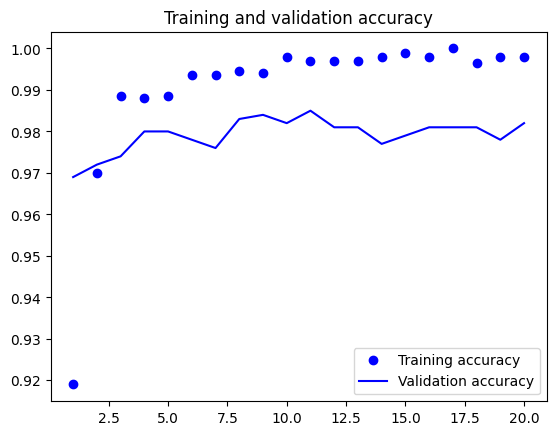

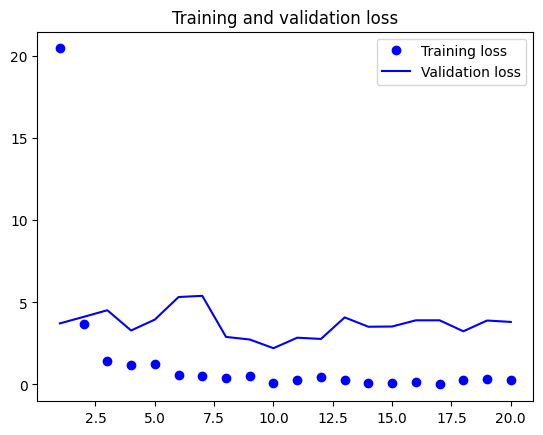

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")

plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the
task at hand. This won’t always be the case when you use pretrained features.

## Approach 2: Feature extraction with Data Augmentation

 We will first freeze the convolutional base. Freezing a layer or set of
 layers means preventing their weights from being updated during training. If we don’t
 do this, the representations that were previously learned by the convolutional base will
 be modified during training.

In [6]:
conv_base  = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
conv_base.trainable = True

print("This is the number of trainable weights "
"before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [8]:
conv_base.trainable = False # we freeze a layer or model by setting its trainable attribute to False.

 Adding a data augmentation stage and a classifier to the convolutional base

In [11]:
data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
   ])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
     optimizer="rmsprop",
     metrics=["accuracy"])

With the above setup, only the weights from the two Dense layers that we added will betrained.

In [12]:
# Using callbacks to save the model during training.
callbacks = [keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_with_data_augmentation.keras", #where the model will be saved
 save_best_only=True,
 monitor="val_loss") #the metric that will be used to determine the "best" model.
 ]


In [13]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1138s 18s/step - accuracy: 0.8175 - loss: 69.1104 - val_accuracy: 0.9650 - val_loss: 4.5156
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.9301 - loss: 8.8311 - val_accuracy: 0.9500 - val_loss: 8.1351
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.9470 - loss: 6.0442 - val_accuracy: 0.9750 - val_loss: 3.2380
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.9651 - loss: 4.5078 - val_accuracy: 0.9740 - val_loss: 2.9063
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.9526 - loss: 3.9273 - val_accuracy: 0.9710 - val_loss: 3.2828
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9691 - loss: 3.6157 - val_accuracy: 0.9680 - val_loss: 5.1775
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9750 - loss: 2.6457 - val_accuracy: 0.9790 - val_loss: 2.7026
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.9790 - loss: 1.8512 - val_acc

In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("feature_extraction_with_data_augmentation.keras")

# Evaluate its performance
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - accuracy: 0.9820 - loss: 2.3899
Loss: 1.9880954027175903, Accuracy: 0.9835000038146973


With featutre extraction combined with data augmentation, we reached an accurcy of 98.3%.